In [1]:
include("Grids.jl")
include("ScatteredInterpolation.jl")
include("Isotropify.jl")

using Grids, Isotropify

# Using Isotropify

Due to the existence of isothermal coordinates, any Riemannian metric on $\mathbb R^2$ is equivalent to an isotropic (conformally Euclidean).

This Julia package implements two algorithms for finding the change of coordinates in which a given 2D metric is conformally Euclidean. Imaginatively enough, they're named isotropify and isotropify2. Of the two, isotropify2 is both faster and better than isotropify.

In this example, we will start with a conformally Euclidean metric and deform it. We'll then hand it to isotropify2, which will recover both the warping and the original metric.

In [2]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
#
# First, create an isotropic metric.
# Then, apply a diffeomorphism to make it anisotropic.
#

grid = RegularGrid(linspace(-1.5,1.5,384),linspace(-1,1,256))
x,y = vars(grid)
y = y.'
nx,ny = size(grid)
Dx,Dy = firstderivatives(grid)

Ix = speye(nx)
Iy = speye(ny)

FDx = kron(Iy,Dx)
FDy = kron(Dy,Ix)

c = (x,y) -> 1.5 + cos(4π*x)*sin(4π*y)

r = hypot.(x,y)
θ = atan2.(y,x)

twist = max.(0, 10(0.75-r).^3)
X = r.*cos(θ+twist)
Y = r.*sin(θ+twist)

Xx = reshape(FDx*vec(X), (nx,ny))
Xy = reshape(FDy*vec(X), (nx,ny))
Yx = reshape(FDx*vec(Y), (nx,ny))
Yy = reshape(FDy*vec(Y), (nx,ny))
Xx[:,  1] = 1.
Xx[:,end] = 1.
Xx[1,  :] = 1.
Xx[end,:] = 1.
Yy[:,  1] = 1.
Yy[:,end] = 1.
Yy[1,  :] = 1.
Yy[end,:] = 1.

creal = c.(x,y)
C = c.(X,Y).^(-2)
g11 = C .* (Xx.^2 + Yx.^2)
g12 = C .* (Xx.*Xy + Yx.*Yy)
g22 = C .* (Xy.^2 + Yy.^2)

g = (g11,g12,g22)
detg = g11.*g22 - g12.^2;


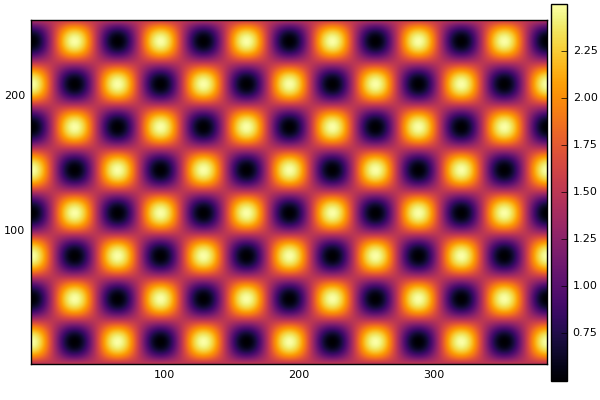

In [4]:
# Show the original metric
heatmap(creal.', ratio=:equal)


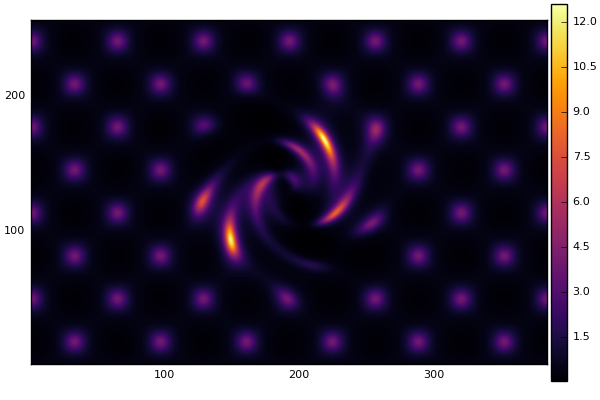


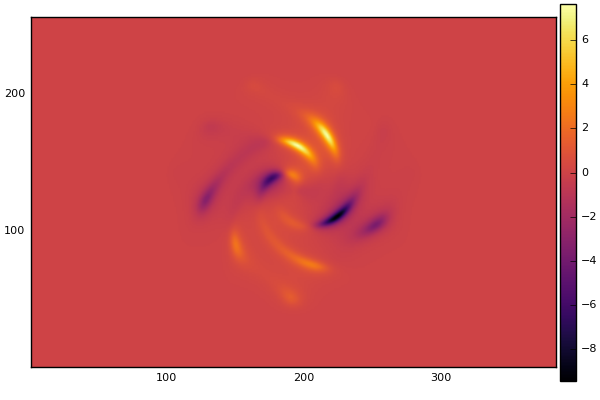


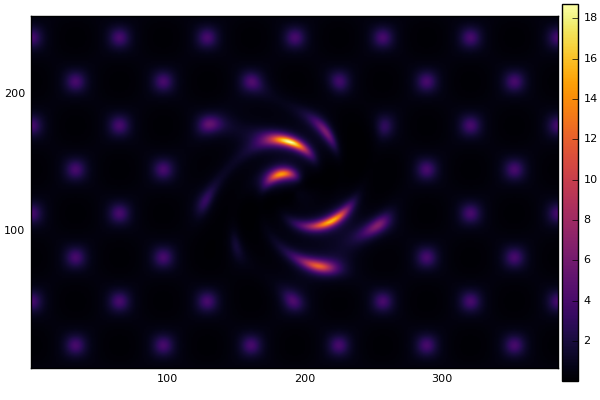

In [5]:
# Show the components of the anisotropic metric
display(heatmap(g11.',ratio=:equal))
display(heatmap(g12.',ratio=:equal))
display(heatmap(g22.',ratio=:equal))

In [6]:
# Now, undo the warping. Isotropify2 computes the warping but does not return it.
@time cnew = isotropify2(g,grid);


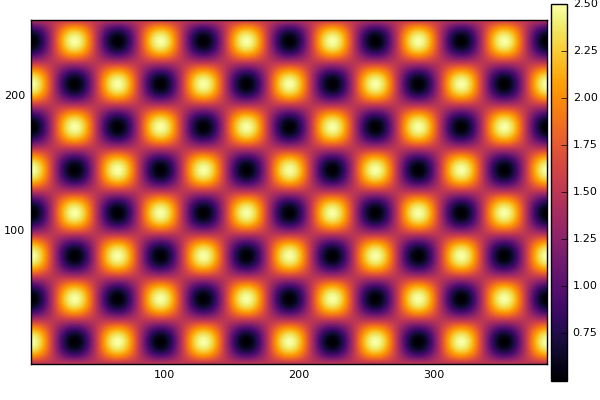

In [7]:
# Check our work.
heatmap(cnew.',ratio=:equal)


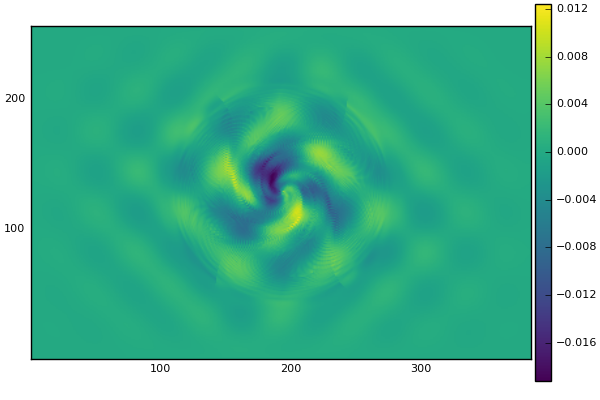

In [8]:
# Plot the error.
heatmap((cnew-creal).',ratio=:equal, c=:viridis)